# Table of Contents
* [Description](#Description)
* [Import Python](#Import-Python)
* [Import Images (Data and OB)](#Import-Images-%28Data-and-OB%29)
	* [Data](#Data)
	* [OB](#OB)
	* [Data/OB](#Data/OB)
		* [Checking that Data and OB Acquisition Time are Equal](#Checking-that-Data-and-OB-Acquisition-Time-are-Equal)
		* [Normalization](#Normalization)
* [Crop Data](#Crop-Data)
* [Export Cropped/Normalized Data](#Export-Cropped/Normalized-Data)


# Description

This notebook will normalize the data.  

# Import Python

In [4]:
import custom_style
custom_style.style()

In [5]:
verbose = False
debugging = False
ipts_group = 'IPTS_17099'

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

import config_handler
import file_handler
import utilities
import gui_widgets
import time_utility
import image_processing

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: we are importing all \
        the python libraries</span>\
        <br><br><span style="font-size: 20px; color:blue"><b>Make sure you wait until a cell\
        is done executing before running another cell!</span>'))

In [6]:
%gui qt

# Import Images (Data and OB)

## Data

In [7]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: select the folder that contains\
 the data you want to normalized!<br>\
 Program will also applied Gamma Filtering (to remove very intense counts)</span>'))
            
data_folder = config_handler.load_config(key='data_folder',
                                        default_value = '/HFIR/CG1D/{}'.format(ipts_group),
                                        group=ipts_group)
new_data_folder = gui_widgets.gui_dname(dir=data_folder,
                                   message='Select the Data Folder ...')
if new_data_folder:
    config_handler.save_config(key='data_folder', value=new_data_folder, group=ipts_group)
    list_of_data_files = glob.glob(new_data_folder + '/*.tiff')

In [8]:
display(HTML('<span style="font-size: 20px; color:blue">Define threshold: <br><br>\
 Example: threshold = 0.1 means that a pixel will be filtered out if 0.1 * pixel_value\
 is above > mean counts of entire image</span>'))

threshold_widget = widgets.FloatSlider(value=0.1, 
                                      min=0,
                                      max=1,
                                       step=0.05,
                                      description='Threshold')
display(threshold_widget)

In [9]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: the program is now loading and \
applying a gamma filtering on all the data...\
Please Be Patient!</span>'))

threshold = threshold_widget.value

w = widgets.IntProgress()
w.max = len(list_of_data_files)
display(w)

data_array = []
for _index, _file in enumerate(list_of_data_files):
    _image = file_handler.load_data(_file)
    _image = image_processing.single_gamma_filtering(_image, threshold=threshold)
    data_array.append(_image)
    w.value = _index + 1
    
print("we loaded {} files".format(len(list_of_data_files)))

we loaded 418 files


## OB

In [10]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: select the Open Beam (OB) file(s)!<br>\
Program will load and gamma filter the data<br><br>\
<b>Make sure you are using OB files that have the same exposusre time as the data!</b> </span>'))

ob_folder = config_handler.load_config(key='ob_folder',
                                        default_value = os.path.dirname(data_folder),
                                        group=ipts_group)
list_ob_files = gui_widgets.gui_fname(dir=ob_folder,
                                       message='Select the OB Files...',
                                         ext='tiff')
if list_ob_files:
    config_handler.save_config(key='ob_folder', value=os.path.dirname(list_ob_files[0]), group=ipts_group)


In [11]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: the program is now loading all the OB...\
Please Be Patient!</span>'))

w = widgets.IntProgress()
w.max = len(list_ob_files)
display(w)

ob_array = []
for _index, _file in enumerate(list_ob_files):
    _image = file_handler.load_data(_file)
    _image = image_processing.single_gamma_filtering(_image, threshold=threshold)
    ob_array.append(_image)
    w.value = _index + 1
    
mean_ob = np.mean(ob_array, axis=0)

## Data/OB

### Checking that Data and OB Acquisition Time are Equal

In [12]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: we are now checking to make sure that the \
exposure time of the data and the OB are identical!</span>'))

# select 2 random file from the list of data and ob
nbr_data = len(list_of_data_files)
random_data_index = np.random.randint(0, nbr_data)

nbr_ob = len(list_ob_files)
random_ob_index = np.random.randint(0, nbr_ob)

# retrieving collection_time for both files
data_exposure_time = time_utility.retrieve_exposure_time(list_of_data_files[random_data_index])
ob_exposure_time = time_utility.retrieve_exposure_time(list_ob_files[random_ob_index])

if not (data_exposure_time == ob_exposure_time):
    display(HTML('<span style="font-size: 20px; color:red">=> RESULT: FAILED! </span>'))
    display(HTML('<span style="font-size: 20px; color:red">==> data exposure time: ' \
                 + str(data_exposure_time) + 's <span>'))
    display(HTML('<span style="font-size: 20px; color:red">==> ob exposure time: ' \
                 + str(ob_exposure_time) + 's <span>'))
    display(HTML('<span style="font-size: 20px; color:blue">SOLUTION: Reload the correct OB files<span>'))

else:
    display(HTML('<span style="font-size: 20px; color:blue">=> RESULT: OK! (exposure time: ' \
                 + str(data_exposure_time) + 's) </span>'))


### Normalization

In [13]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: here, we are performing the NORMALIZATION.<br><br> \
But first we need to clean the data by removing \
all the 0 values from the OB (denominator).<br> Then bringing them back after the normalization!\
<br><br><b>This step can take up to a few minutes... BE PATIENT Please!</b></span>'))

mean_ob[mean_ob == 0] = np.NAN
normalized_data = np.divide(data_array, mean_ob)
normalized_data[normalized_data == np.NAN] = 0

In [14]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: in the next cell, you visualize the result \
of the normalization. Play with the slider to browse through the images.</span>'))

0

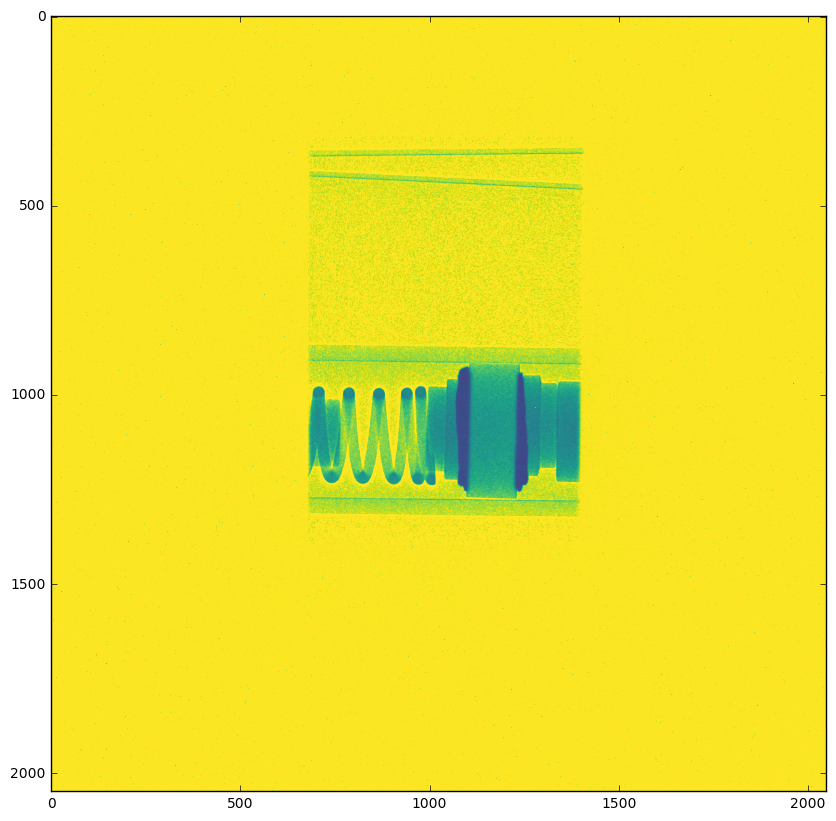

In [15]:
def plot_images(image_index, image_size):
    
    fig = plt.figure(figsize=(image_size, image_size))
    ax_img = plt.subplot(111)
    ax_img.imshow(normalized_data[image_index], cmap='viridis', vmin=0, vmax=1)

    
    return image_index
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(normalized_data)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'),
                  image_size = widgets.IntSlider(min=5,
                                                max=20,
                                                value=10))

# Crop Data 

In [16]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: in order to only focus on the data of interest, \
you have here the option to crop your images by changing the left, top, widht and height sliders.<br><br> \
The main advantage of this crop will be that the data set will be smaller and then, the calculation will be faster!</span>'))

[1050, 880, 150, 400]

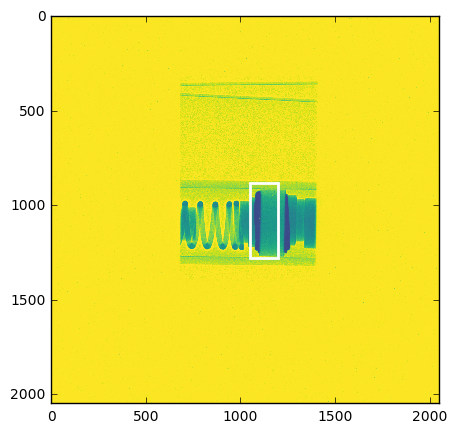

In [17]:
[height, width] = np.shape(normalized_data[0])

def plot_images(image_index, x_left, y_top, width, height, image_size):
    
    fig = plt.figure(figsize=(image_size, image_size))
    ax_img = plt.subplot(111)
    ax_img.imshow(normalized_data[image_index],
                 cmap='viridis',
                 vmin=0, vmax=1)
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [x_left, y_top, width, height]
    
crop = interact(plot_images,
                  image_index = widgets.IntSlider(min=0,
                                                 max=len(normalized_data)-1,
                                                 value=0,
                                                 description='File Index'),
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=980,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=880,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=100,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=400,
                                            description='Height'),
                image_size = widgets.IntSlider(min=5,
                                                max=20,
                                                value=1))

In [18]:
display(HTML('<span style="font-size: 20px; color:blue">Explanation: We are here saving the parameters your defined\
in the previous cell and we also crop the entire data stack!</span>'))

[x_left, y_top, width, height] = crop.widget.result
cropped_data = [_data[y_top:y_top+height, x_left:x_left+width] for _data in normalized_data]

display(HTML('<span style="font-size: 20px; color:blue">In the next cell, you can visualize the new data \
set after cropping!</span>'))

343

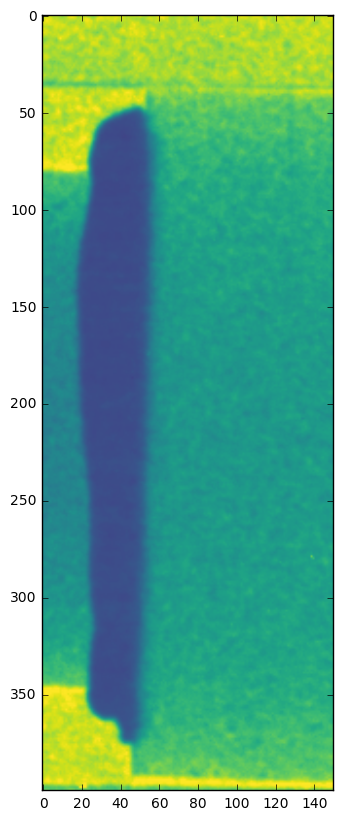

In [19]:
def plot_images(image_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(cropped_data[image_index], cmap='viridis', vmin=0, vmax=1)

    
    return image_index
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(normalized_data)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'))

# Export Cropped/Normalized Data

In [20]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: We gonna save the new data set into tiff files.\
<br><br>Please select where you want to save those files....<b>Make sure the folder you select is empty!</b>\
<br><br>HELP: you are working with the following data set: ' +  os.path.basename(data_folder)  + '</span>'))

output_folder = config_handler.load_config(key='output_folder', group=ipts_group)
new_output_folder = gui_widgets.gui_dname(dir=output_folder,
                                   message='Select the Output Folder ...')
if new_output_folder:
    config_handler.save_config(key='output_folder', value=new_output_folder, group=ipts_group)
    
    short_list_of_data_files = [os.path.basename(_file) for _file in list_of_data_files]

    w = widgets.IntProgress()
    w.max = len(short_list_of_data_files)
    display(w)
    
    for _index, _short_file in enumerate(short_list_of_data_files):
        _full_file_name = os.path.join(new_output_folder, _short_file)
        _data = cropped_data[_index]
        file_handler.make_tiff(data=_data, filename=_full_file_name)
        w.value = _index+1
        
    print("TIFF files have been created in the folder: {}".format(new_output_folder))
    

TIFF files have been created in the folder: /SNS/users/j35/IPTS/17099/normalized
